In [1]:
!python -c "import torch; print(torch.__version__)"

2.1.0+cu121


In [2]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [3]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv

In [4]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [5]:
class GCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      n_layers_mlp: int,
      dropout_ratio: float = 0.3):
    super(GCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """


    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.n_classes = n_classes
    self.n_layers = n_layers
    self.n_layers_mlp = n_layers_mlp
    self.dropout_ratio = dropout_ratio
    # Define a list to hold the layers
    self.layers = nn.ModuleList()

    # Create the GCN layers based on the specified number of layers
    if n_layers>0:
        self.layers.append(GCNConv(self.input_dim, self.hid_dim))
        for _ in range(n_layers-1):
            self.layers.append(GCNConv(self.hid_dim, self.hid_dim))
            for i in range(n_layers_mlp):
                self.layers.append(torch.nn.Sequential(torch.nn.Linear(self.hid_dim, self.hid_dim)))

    self.lin0 = nn.Linear(self.input_dim,self.n_classes)
    self.dropout = nn.Dropout(p=self.dropout_ratio)
    m = nn.Softmax()


  def forward(self, X, A) -> torch.Tensor:

    if self.n_layers==0:
        X = F.relu(self.lin0(X))
        X = self.dropout(X)
    else:
        for layer in self.layers:
            if isinstance(layer, GCNConv):
                X = F.relu(layer(X, A))
                X = self.dropout(X)
            else:
                X = F.relu(layer(X))
                X = self.dropout(X)
    return X


  def generate_node_embeddings(self, X, A) -> torch.Tensor:

    # Function to get node embeddings from the last layer
    if self.n_layers==0:
        X = F.relu(self.lin0(X))
    else:
        for layer in self.layers:
            if isinstance(layer, GCNConv):
                X = F.relu(layer(X, A))
            else:
                X = F.relu(layer(X))
    return X


  def param_init(self):
    self.lin0.reset_parameters()

    for layer in self.layers:
        if isinstance(layer, GCNConv):
            # Reset parameters for GCN layers
            layer.reset_parameters()
        elif isinstance(layer, nn.Sequential):
            # Extract linear layers from the Sequential block and reset their parameters
            for sub_layer in layer:
                if isinstance(sub_layer, nn.Linear):
                    sub_layer.reset_parameters()


In [6]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [136]:
List = []

In [137]:
def train(
    params: typing.Dict
) -> torch.nn.Module:
  """
    This function trains a node classification model and returns the trained model object.
  """
  # set device
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # load dataset
  data = dataset.data
  data = data.to(device)

  # Update parameters
  params["n_classes"] = dataset.num_classes # number of target classes
  params["input_dim"] = dataset.num_features # size of input features

  # Set a model
  if params['model_name'] == 'GCN':
      model = GCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        params["n_layers_mlp"]
        ).to(device)
  elif params['model_name'] == 'SkipGCN':
      model = SkipGCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
      ).to(device)
  elif params['model_name'] == 'JumpKnowGCN':
      model = JumpKnowGCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
      ).to(device)
  else:
      raise NotImplementedError
  model.param_init()

  # Define loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])

  # Initialize variables for early stopping
  last_val_accuracy = 0.0
  best_val_accuracy = 0
  patience_counter = 0
  best_train_loss=10
  # Training loop
  for epoch in range(1, params["epochs"] + 1):

      model.train()
      optimizer.zero_grad()
      logits = model(data.x, data.edge_index)

      # Use the train_mask to compute the training loss
      train_loss = criterion(logits[data.train_mask], data.y[data.train_mask])

      # Backward and optimize
      train_loss.backward()
      optimizer.step()

      # Evaluate on the validation set
      val_accuracy = evaluate(model, data, data.val_mask)

      print(f'Epoch {epoch}/{params["epochs"]}, Train Loss: {train_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}, Best_Val_Acc: {best_val_accuracy:.4f}, Best_train_loss: {best_train_loss:.4f}')

      # Check for early stopping
      if train_loss  < best_train_loss :
          best_train_loss = train_loss
      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
      if val_accuracy > last_val_accuracy:
          #best_val_accuracy = val_accuracy
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= params["max_patience"]:
              print(f'Early stopping at epoch {epoch} due to no improvement in validation accuracy.')
              break
      last_val_accuracy=val_accuracy
  List.append((training_params["n_layers"],best_train_loss, best_val_accuracy))
  return model

In [138]:
def evaluate(
    model,
    data,
    mask
):

    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
    predictions = logits[mask].argmax(dim=1)
    accuracy = accuracy_score(data.y[mask].cpu().numpy(), predictions.cpu().numpy())
    return accuracy

In [139]:
training_params = {
    "lr": 0.0005,  # learning rate
    "weight_decay": 0.005,  # weight_decay
    "epochs": 10000,  # number of total training epochs
    "max_patience": 1000, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "n_layers": None, # number of layers of MLP
    "model_name": "GCN"
}


In [140]:
torch.manual_seed(123) # set seed

In [141]:
# training_params["n_layers"] = 0
# training_params["n_layers_mlp"] = 10
# model_0_layer = train(training_params)

In [142]:
# training_params["n_layers"] = 1
# training_params["n_layers_mlp"] = 10
# model_1_layer = train(training_params)

In [143]:
training_params["n_layers"] = 2
training_params["n_layers_mlp"] = 0
model_0_layer = train(training_params)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Train Loss: 1.2024, Validation Accuracy: 0.7780, Best_Val_Acc: 0.8060, Best_train_loss: 0.8091
Epoch 5002/10000, Train Loss: 1.1498, Validation Accuracy: 0.7740, Best_Val_Acc: 0.8060, Best_train_loss: 0.8091
Epoch 5003/10000, Train Loss: 1.3318, Validation Accuracy: 0.7740, Best_Val_Acc: 0.8060, Best_train_loss: 0.8091
Epoch 5004/10000, Train Loss: 1.0392, Validation Accuracy: 0.7760, Best_Val_Acc: 0.8060, Best_train_loss: 0.8091
Epoch 5005/10000, Train Loss: 1.4771, Validation Accuracy: 0.7780, Best_Val_Acc: 0.8060, Best_train_loss: 0.8091
Epoch 5006/10000, Train Loss: 1.3855, Validation Accuracy: 0.7780, Best_Val_Acc: 0.8060, Best_train_loss: 0.8091
Epoch 5007/10000, Train Loss: 1.5321, Validation Accuracy: 0.7800, Best_Val_Acc: 0.8060, Best_train_loss: 0.8091
Epoch 5008/10000, Train Loss: 1.3314, Validation Accuracy: 0.7800, Best_Val_Acc: 0.8060, Best_train_loss: 0.8091
Epoch 5009/10000, Train Loss: 1.4463, Validat

In [144]:
training_params["n_layers"] = 2
training_params["n_layers_mlp"] = 1
model_1_layer = train(training_params)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Train Loss: 1.4161, Validation Accuracy: 0.7800, Best_Val_Acc: 0.8060, Best_train_loss: 0.7320
Epoch 5002/10000, Train Loss: 1.3804, Validation Accuracy: 0.7800, Best_Val_Acc: 0.8060, Best_train_loss: 0.7320
Epoch 5003/10000, Train Loss: 1.5183, Validation Accuracy: 0.7780, Best_Val_Acc: 0.8060, Best_train_loss: 0.7320
Epoch 5004/10000, Train Loss: 1.4160, Validation Accuracy: 0.7760, Best_Val_Acc: 0.8060, Best_train_loss: 0.7320
Epoch 5005/10000, Train Loss: 1.6009, Validation Accuracy: 0.7760, Best_Val_Acc: 0.8060, Best_train_loss: 0.7320
Epoch 5006/10000, Train Loss: 1.2025, Validation Accuracy: 0.7760, Best_Val_Acc: 0.8060, Best_train_loss: 0.7320
Epoch 5007/10000, Train Loss: 1.4546, Validation Accuracy: 0.7760, Best_Val_Acc: 0.8060, Best_train_loss: 0.7320
Epoch 5008/10000, Train Loss: 1.3008, Validation Accuracy: 0.7780, Best_Val_Acc: 0.8060, Best_train_loss: 0.7320
Epoch 5009/10000, Train Loss: 0.9962, Validat

In [145]:
training_params["n_layers"] = 2
training_params["n_layers_mlp"] = 2
model_2_layer = train(training_params)

Epoch 1/10000, Train Loss: 4.1779, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 10.0000
Epoch 2/10000, Train Loss: 4.1718, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 4.1779
Epoch 3/10000, Train Loss: 4.1725, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 4.1718
Epoch 4/10000, Train Loss: 4.1670, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 4.1718
Epoch 5/10000, Train Loss: 4.1714, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 4.1670
Epoch 6/10000, Train Loss: 4.1673, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 4.1670
Epoch 7/10000, Train Loss: 4.1715, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 4.1670
Epoch 8/10000, Train Loss: 4.1659, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 4.1670
Epoch 9/10000, Train Loss: 4.1638, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 4.1659
Epoch 10/

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Train Loss: 0.9733, Validation Accuracy: 0.7740, Best_Val_Acc: 0.7880, Best_train_loss: 0.7185
Epoch 5002/10000, Train Loss: 1.3954, Validation Accuracy: 0.7780, Best_Val_Acc: 0.7880, Best_train_loss: 0.7185
Epoch 5003/10000, Train Loss: 1.2800, Validation Accuracy: 0.7740, Best_Val_Acc: 0.7880, Best_train_loss: 0.7185
Epoch 5004/10000, Train Loss: 1.5202, Validation Accuracy: 0.7720, Best_Val_Acc: 0.7880, Best_train_loss: 0.7185
Epoch 5005/10000, Train Loss: 1.5009, Validation Accuracy: 0.7660, Best_Val_Acc: 0.7880, Best_train_loss: 0.7185
Epoch 5006/10000, Train Loss: 1.6124, Validation Accuracy: 0.7620, Best_Val_Acc: 0.7880, Best_train_loss: 0.7185
Epoch 5007/10000, Train Loss: 1.3258, Validation Accuracy: 0.7600, Best_Val_Acc: 0.7880, Best_train_loss: 0.7185
Epoch 5008/10000, Train Loss: 1.1010, Validation Accuracy: 0.7580, Best_Val_Acc: 0.7880, Best_train_loss: 0.7185
Epoch 5009/10000, Train Loss: 1.3229, Validat

In [146]:
training_params["n_layers"] = 2
training_params["n_layers_mlp"] = 4
model_4_layer = train(training_params)

Epoch 1/10000, Train Loss: 4.1569, Validation Accuracy: 0.1620, Best_Val_Acc: 0.0000, Best_train_loss: 10.0000
Epoch 2/10000, Train Loss: 4.1611, Validation Accuracy: 0.1620, Best_Val_Acc: 0.1620, Best_train_loss: 4.1569


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Train Loss: 1.2202, Validation Accuracy: 0.6160, Best_Val_Acc: 0.6580, Best_train_loss: 0.7936
Epoch 5002/10000, Train Loss: 1.0664, Validation Accuracy: 0.6180, Best_Val_Acc: 0.6580, Best_train_loss: 0.7936
Epoch 5003/10000, Train Loss: 1.0926, Validation Accuracy: 0.6100, Best_Val_Acc: 0.6580, Best_train_loss: 0.7936
Epoch 5004/10000, Train Loss: 1.3645, Validation Accuracy: 0.6160, Best_Val_Acc: 0.6580, Best_train_loss: 0.7936
Epoch 5005/10000, Train Loss: 1.1394, Validation Accuracy: 0.6100, Best_Val_Acc: 0.6580, Best_train_loss: 0.7936
Epoch 5006/10000, Train Loss: 1.4744, Validation Accuracy: 0.6140, Best_Val_Acc: 0.6580, Best_train_loss: 0.7936
Epoch 5007/10000, Train Loss: 1.3098, Validation Accuracy: 0.6120, Best_Val_Acc: 0.6580, Best_train_loss: 0.7936
Epoch 5008/10000, Train Loss: 1.2555, Validation Accuracy: 0.6040, Best_Val_Acc: 0.6580, Best_train_loss: 0.7936
Epoch 5009/10000, Train Loss: 1.0407, Validat

In [147]:
training_params["n_layers"] = 2
training_params["n_layers_mlp"] = 10
model_10_layer = train(training_params)

Epoch 1/10000, Train Loss: 4.1589, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 10.0000
Epoch 2/10000, Train Loss: 4.1620, Validation Accuracy: 0.0000, Best_Val_Acc: 0.0000, Best_train_loss: 4.1589
Epoch 3/10000, Train Loss: 4.1558, Validation Accuracy: 0.1560, Best_Val_Acc: 0.0000, Best_train_loss: 4.1589
Epoch 4/10000, Train Loss: 4.1557, Validation Accuracy: 0.1560, Best_Val_Acc: 0.1560, Best_train_loss: 4.1558
Epoch 5/10000, Train Loss: 4.1403, Validation Accuracy: 0.1560, Best_Val_Acc: 0.1560, Best_train_loss: 4.1557
Epoch 6/10000, Train Loss: 4.1430, Validation Accuracy: 0.1560, Best_Val_Acc: 0.1560, Best_train_loss: 4.1403
Epoch 7/10000, Train Loss: 4.1363, Validation Accuracy: 0.1560, Best_Val_Acc: 0.1560, Best_train_loss: 4.1403
Epoch 8/10000, Train Loss: 4.1367, Validation Accuracy: 0.1560, Best_Val_Acc: 0.1560, Best_train_loss: 4.1363
Epoch 9/10000, Train Loss: 4.1346, Validation Accuracy: 0.1560, Best_Val_Acc: 0.1560, Best_train_loss: 4.1363
Epoch 10/

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Train Loss: 2.8888, Validation Accuracy: 0.1220, Best_Val_Acc: 0.3160, Best_train_loss: 2.5803
Epoch 5002/10000, Train Loss: 2.8611, Validation Accuracy: 0.1220, Best_Val_Acc: 0.3160, Best_train_loss: 2.5803
Epoch 5003/10000, Train Loss: 2.9592, Validation Accuracy: 0.1220, Best_Val_Acc: 0.3160, Best_train_loss: 2.5803
Epoch 5004/10000, Train Loss: 3.0517, Validation Accuracy: 0.1220, Best_Val_Acc: 0.3160, Best_train_loss: 2.5803
Epoch 5005/10000, Train Loss: 3.0744, Validation Accuracy: 0.1220, Best_Val_Acc: 0.3160, Best_train_loss: 2.5803
Epoch 5006/10000, Train Loss: 2.8325, Validation Accuracy: 0.1220, Best_Val_Acc: 0.3160, Best_train_loss: 2.5803
Epoch 5007/10000, Train Loss: 2.7944, Validation Accuracy: 0.1220, Best_Val_Acc: 0.3160, Best_train_loss: 2.5803
Epoch 5008/10000, Train Loss: 3.0043, Validation Accuracy: 0.1220, Best_Val_Acc: 0.3160, Best_train_loss: 2.5803
Epoch 5009/10000, Train Loss: 2.8261, Validat

In [148]:
# training_params["n_layers"] = 10
# training_params["n_layers_mlp"] = 1
# model_10_layer = train(training_params)

In [149]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [150]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
  """
    Args:
      model: model object for generating features

    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
  """

  data = dataset.data
  model.eval()
  with torch.no_grad():
    node_embeddings = model.generate_node_embeddings(data.x, data.edge_index).cpu().numpy()

  tsne = TSNE(n_components=2, random_state=42)
  # Filter node_embeddings and labels for the validation set
  val_node_embeddings = node_embeddings[data.val_mask.cpu().numpy()]
  val_labels = data.y[data.val_mask].cpu().numpy()

  reduced_features = tsne.fit_transform(val_node_embeddings)

  df = pd.DataFrame(data={"dimension 1": reduced_features[:, 0], "dimension 2": reduced_features[:, 1], "labels": val_labels})

  return df

In [151]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "2_layer": dimension_reduction(model_2_layer),
    "4_layer": dimension_reduction(model_4_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

In [152]:
def visualise(feature_dict: typing.Dict) -> None:

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    fig.suptitle('Node Embeddings Visualization')

    # Draw scatter plots for each model
    for i, (name, df) in enumerate(feature_dict.items()):
        ax = axes[i // 2, i % 2]
        ax.scatter(df['dimension 1'], df['dimension 2'], c=df['labels'], cmap='viridis', s=10, alpha=0.7)
        ax.set_title(f'{name}')

    plt.show()

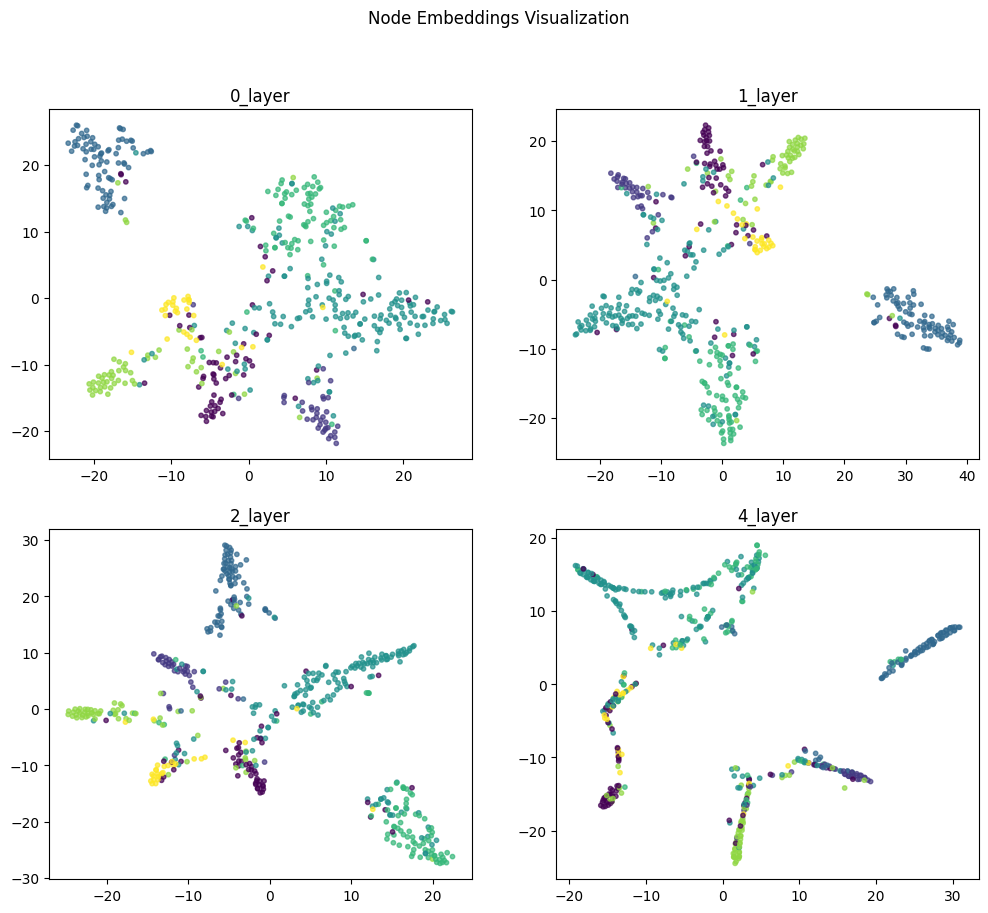

In [153]:
visualise(feature_dict)

In [154]:
feature_dict2 = {
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


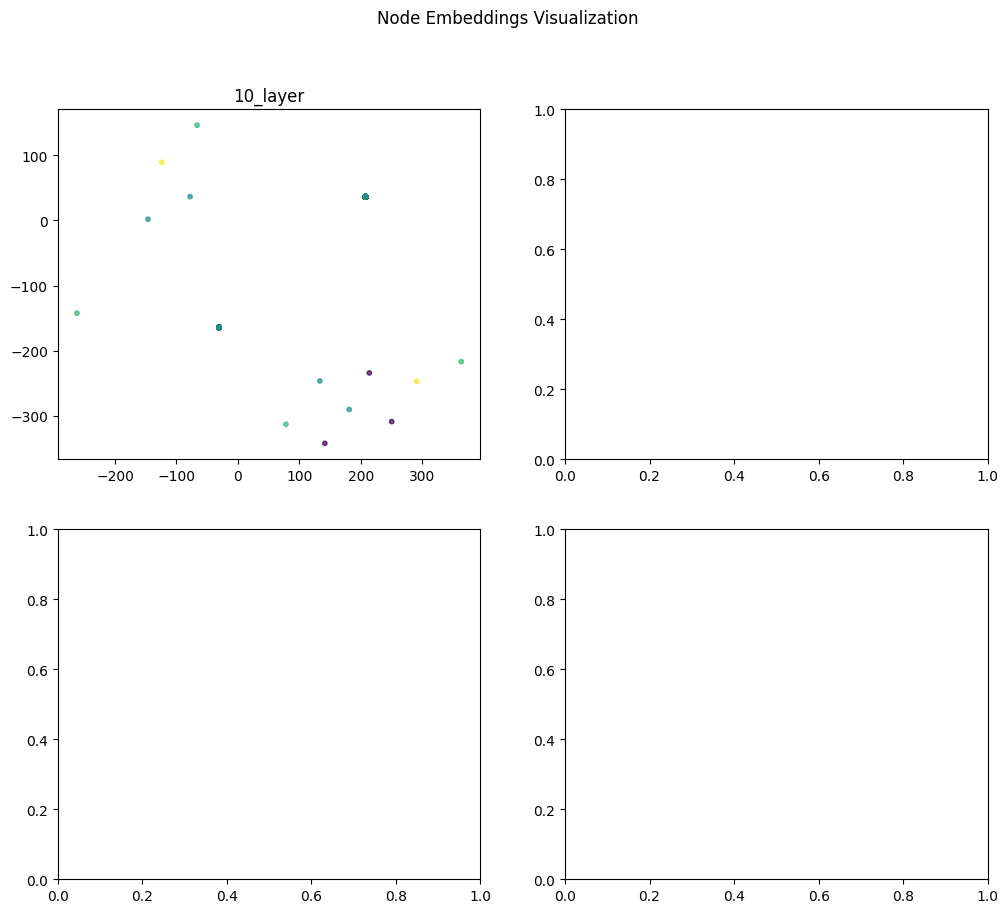

In [155]:
visualise(feature_dict2)

In [156]:
print(List)

[(2, tensor(0.7405, device='cuda:0', grad_fn=<NllLossBackward0>), 0.806), (2, tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward0>), 0.806), (2, tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward0>), 0.788), (2, tensor(0.7877, device='cuda:0', grad_fn=<NllLossBackward0>), 0.658), (2, tensor(2.5376, device='cuda:0', grad_fn=<NllLossBackward0>), 0.316)]
